# Certainty with Plateau Width

In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np
from qrsc.utils.annotationutils import trigger_points

# Clean ECG Signals
signal_dir = "../physionet.org/files/mitdb/1.0.0"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109"
])
sampto = 10000

clean_records, triggers = read_records(signal_dir, names, sampto)
clean_records, triggers = np.array(clean_records), np.array(triggers)

# Noise template
noise_path = '../physionet.org/files/nstdb/1.0.0/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from qrsc.utils.noiseutils import apply_noise_db

snr = 3

noisy_records = np.array([
    apply_noise_db(clean_record, noise_template, snr)
    for clean_record in clean_records])

## Create Detector

In [5]:
from qrsc.detectors import XiangDetector

xd = XiangDetector(
    name='XD', batch_size=32, window_size=40, detection_size=30,
    aux_ratio=5, epochs=3)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Helpers

In [6]:
def select_certain(trigger, certainty_threshold):
    return [
        trigger_point
        for trigger_point, certainty in trigger
        if certainty >= certainty_threshold]

## Train and Test

In [7]:
from collections import defaultdict
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut
from qrsc.utils.evaluationutils import trigger_metrics
from qrsc.utils.triggerutils import signal_to_points

spike_widths = [0, 30]
certainty_thresholds = np.arange(0., 1.1, .1)
metrics = defaultdict(list)

cv = LeaveOneOut()

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}: {}".format(step_id, cv.get_n_splits(names), test_indexes))
    
    # Training
    train_records = clean_records[train_indexes]
    train_triggers = triggers[train_indexes]
    xd.reset()
    with redirect_stdout(StringIO()):
        xd.train(train_records, train_triggers)

    # Testing
    for spike_width in spike_widths:
        test_record = noisy_records[test_indexes][0]
        test_trigger = triggers[test_indexes][0]
    
        trigger_signal = xd.trigger_signal(test_record)
        detected_trigger = list(zip(
            *signal_to_points(
                trigger_signal, threshold=0.5, with_certainty=True,
                spike_width=None if spike_width == 0 else spike_width )))
    
        certain_triggers = [
            select_certain(detected_trigger, certainty_threshold)
            for certainty_threshold in certainty_thresholds]
    
        metrics[spike_width].append([
            trigger_metrics(test_trigger, certain_trigger, 5)
            for certain_trigger in certain_triggers])

Step 1/10: [0]
Instructions for updating:
Use tf.cast instead.
Step 2/10: [1]
Step 3/10: [2]
Step 4/10: [3]
Step 5/10: [4]
Step 6/10: [5]
Step 7/10: [6]
Step 8/10: [7]
Step 9/10: [8]
Step 10/10: [9]


## Calculate Statistics

In [8]:
from qrsc.utils.evaluationutils import sensitivity, ppv, f1

counts, ses, ppvs, f1s = {}, {}, {}, {}

for spike_width in spike_widths:
    counts[spike_width] = np.array([
        [tp+fp for tp, tn, fp, fn in test_result]
        for test_result in metrics[spike_width]])

    ses[spike_width] = np.array([
        [sensitivity(tp, fn) for tp, tn, fp, fn in test_result]
        for test_result in metrics[spike_width]])

    ppvs[spike_width] = np.array([
        [ppv(tp, fp) for tp, tn, fp, fn in test_result]
        for test_result in metrics[spike_width]])

    f1s[spike_width] = np.array([
        [f1(tp, fp, fn) for tp, tn, fp, fn in test_result]
        for test_result in metrics[spike_width]])

In [9]:
count_medians, se_medians, ppv_medians, f1_medians = {}, {}, {}, {}
count_percentiles, se_percentiles, ppv_percentiles, f1_percentiles = {}, {}, {}, {}

for spike_width in spike_widths:
    count_medians[spike_width] = np.nanmedian(counts[spike_width], axis=0)
    count_percentiles[spike_width] = [
        count_medians[spike_width] - np.nanpercentile(counts[spike_width], 25, axis=0),
        np.nanpercentile(counts[spike_width], 75, axis=0) - count_medians[spike_width]]

    se_medians[spike_width] = np.nanmedian(ses[spike_width], axis=0)
    se_percentiles[spike_width] = [
        se_medians[spike_width] - np.nanpercentile(ses[spike_width], 25, axis=0),
        np.nanpercentile(ses[spike_width], 75, axis=0) - se_medians[spike_width]]

    ppv_medians[spike_width] = np.nanmedian(ppvs[spike_width], axis=0)
    ppv_percentiles[spike_width] = [
        ppv_medians[spike_width] - np.nanpercentile(ppvs[spike_width], 25, axis=0),
        np.nanpercentile(ppvs[spike_width], 75, axis=0) - ppv_medians[spike_width]]

    f1_medians[spike_width] = np.nanmedian(f1s[spike_width], axis=0)
    f1_percentiles[spike_width] = [
        f1_medians[spike_width] - np.nanpercentile(f1s[spike_width], 25, axis=0),
        np.nanpercentile(f1s[spike_width], 75, axis=0) - f1_medians[spike_width]]

/home/Jonas.Chromik/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/Jonas.Chromik/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Plot

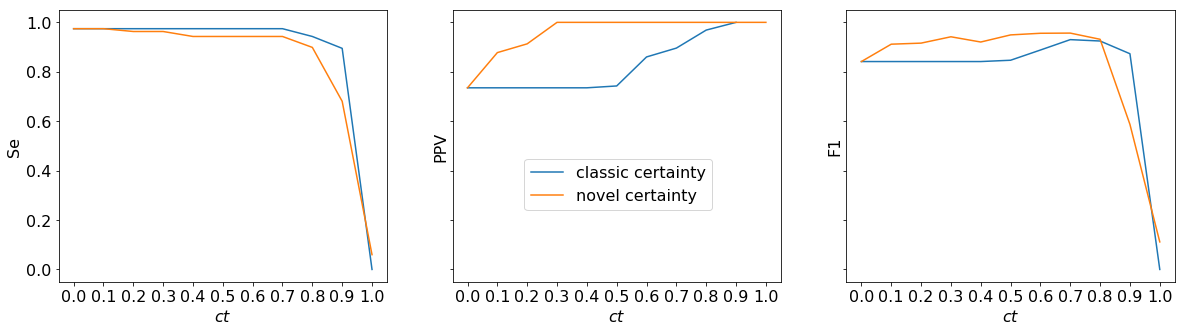

In [10]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

fig_perf_mutli, (ax_se, ax_ppv, ax_f1) = plt.subplots(ncols=3, sharey=True)
fig_perf_mutli.set_size_inches(20,5)

ax_se.set_ylabel("Se")
ax_ppv.set_ylabel("PPV")
ax_f1.set_ylabel("F1")

ax_se.set_xlabel(r"$ct$")
ax_ppv.set_xlabel(r"$ct$")
ax_f1.set_xlabel(r"$ct$")

ax_se.set_xticks(certainty_thresholds)
ax_ppv.set_xticks(certainty_thresholds)
ax_f1.set_xticks(certainty_thresholds)

# Without expected plateau width
ax_se.plot(certainty_thresholds, se_medians[0], label="classic certainty")
ax_ppv.plot(certainty_thresholds, ppv_medians[0])
ax_f1.plot(certainty_thresholds, f1_medians[0])

# Without expected plateau width
ax_se.plot(certainty_thresholds, se_medians[30], label="novel certainty")
ax_ppv.plot(certainty_thresholds, ppv_medians[30])
ax_f1.plot(certainty_thresholds, f1_medians[30])

fig_perf_mutli.legend(bbox_to_anchor=(.5, .5))
    
plt.show()

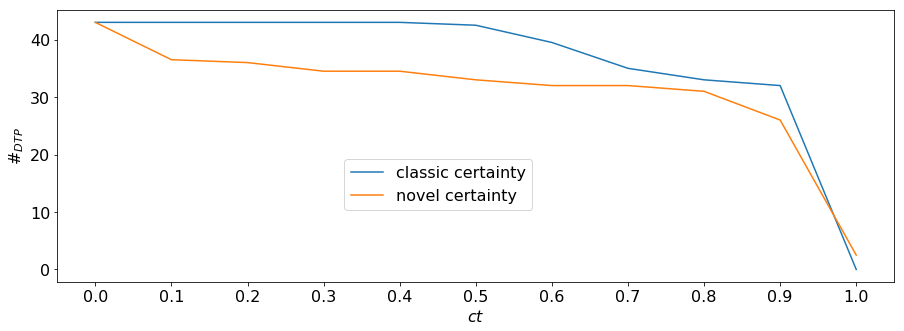

In [11]:
ctdm_multi, ax = plt.subplots()
ctdm_multi.set_size_inches(15, 5)

ax.plot(certainty_thresholds, count_medians[0], label="classic certainty")
ax.plot(certainty_thresholds, count_medians[30], label="novel certainty")

ax.set_xticks(certainty_thresholds)
ax.set_xlabel(r"$ct$")
ax.set_ylabel(r"$\#_{DTP}$")

ctdm_multi.legend(bbox_to_anchor=(.5, .5))

plt.show()

In [12]:
save = True

if save:
    fig_perf_mutli.savefig(
        '../generated/figures/certainty_plateau_width_high_threshold_performance.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)
    ctdm_multi.savefig(
        '../generated/figures/certainty_plateau_width_high_threshold_ctdm.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0.1)